<div align="center"> 
<img src='./img/header.png'/>
</div>

## [Global Ice Velocities](https://its-live.jpl.nasa.gov/)
    
The Inter-mission Time Series of Land Ice Velocity and Elevation (ITS_LIVE) project facilitates ice sheet, ice shelf and glacier research by providing a globally comprehensive and temporally dense multi-sensor record of land ice velocity and elevation with low latency.

Scene-pair velocities generated from satellite optical and radar imagery.

* Coverage: All land ice
* Date range: 1985-present
* Resolution: 240m
* Scene-pair separation: 6 to 546 days


---

* If you want to query our API directly using  your own software here is the OpenApi endpoint https://staging.nsidc.org/apps/itslive-search/docs
* For questions about this notebook and the dataset please contact users services at uso@nsidc.org


## Build a cube

This notebook demonstrates _ITSCube_ class which is used to generate time series of velocity pair granules for the region of interest which is defined by a polygon in target UTM projection.

### ITSCube:
1. Submits a query to the API to get a list of ITS_LIVE granules qualifying to be included into the cube.
   * Polygon UTM coordinates are converted to longitude/latitude coordinates in order for them to be passed to the API search query.
1. Accesses ITS_LIVE granules, which are stored in AWS S3 bucket, remotely without downloading them to the local storage.
1. Filters each ITS_LIVE granule by region of interest, and loads variables data only for the region.
1. Writes cube data (after processing 1000 granules at a time, which is a default setting for the ITSCube.NUM_GRANULES_TO_WRITE class attribute) to Zarr store to avoid out of memory failures.

The following logic is followed in qualifying the granule for inclusion into the data cube:
1. Ignores granules that don't contain valid data for the region of interest. It keeps track of a number of such ignored granules.
1. Ignores granules that are defined in other than target UTM projection. It keeps track of a number of such ignored granules.
1. In a case when multiple granules exist for the same middle date (middle date + time displacement as milliseconds), it picks the
   newest processed granule. This step is done based on the filename of each granule, so all duplicate granules are ignored before any read access to the S3 bucket. 

### ITSCube TODO
 * Interpolate polygon edges (lat/lon coordinates) to get better region inclusion when submitting granule query to the search API

In [1]:
# Auto-reload all modules to pick up latest edits to dependent modules
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Enable output of all statements in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Set up Dask diagnostics

In [2]:
# from dask.distributed import Client
# client = Client(processes=True, n_workers=8)
# client

#### Prepare parameters for the cube generation, including ITSLIVE API parameters to search for granules of interest

In [7]:
from itscube import ITSCube

# Create polygon as a square around the centroid in target '32628' UTM projection
# Projection for the polygon coordinates
projection = '32628'

# Centroid for the tile in target projection
c_x, c_y = (487462, 9016243)

# Offset in meters (1 pixel=240m): 100 km square (with offset=50km)
off = 50000 
polygon = ((c_x - off, c_y + off), (c_x + off, c_y + off), (c_x + off, c_y - off), (c_x - off, c_y - off), (c_x - off, c_y + off))
print(f"Polygon in UTM {projection}: {polygon}")

# Create cube object
cube = ITSCube(polygon, projection)

# Search API parameters
API_params = {
    'start'               : '2010-01-05',
    'end'                 : '2020-01-01',
    'percent_valid_pixels': 1
}

# Examine only first 100 granules - too slow to access S3 bucket locally
num_granules = 100

Polygon in UTM 32628: ((437462, 9066243), (537462, 9066243), (537462, 8966243), (437462, 8966243), (437462, 9066243))
Longitude/latitude coords for polygon: [-18.853615384172965, 81.6356820300733, -12.689367193215306, 81.64763330453586, -12.91144647782456, 80.75241792169454, -18.483852839771348, 80.74163892715585, -18.853615384172965, 81.6356820300733]


#### Create cube using remote access to S3 granules

In [4]:
# Write cube data to the local Zarr store for now
local_store = 'cube.zarr'

found_urls = cube.create(API_params, local_store, num_granules)

Reading and processing S3 granules:   0%|          | 0/94 [00:00<?, ?it/s]

Number of found by API granules: 55498 (took 5.77430145400001 seconds)
Examining only first 100 out of 55498 found granules
Keeping 94 unique granules


Reading and processing S3 granules: 100%|##########| 94/94 [00:33<00:00,  2.83it/s]


Combine 94 layers to the cube.zarr...
Combined 94 layers (took 1.5798207569999931 seconds)
Wrote 94 layers to cube.zarr (took 1.671013083000048 seconds)
Skipped granules:
      empty data       : 0 (0.0%)
      wrong projection : 0 (0.0%)
      double mid_date  : 6 (6.0%)


### Read cube data from the Zarr store

In [5]:
import xarray as xr

back_zarr = xr.open_zarr(local_store)
back_zarr

<xarray.Dataset>
Dimensions:           (mid_date: 94, x: 341, y: 233)
Coordinates:
  * mid_date          (mid_date) datetime64[ns] 2015-08-05T00:00:00.032000 .....
  * x                 (x) float64 4.376e+05 4.379e+05 ... 5.19e+05 5.192e+05
  * y                 (y) float64 8.966e+06 8.967e+06 ... 9.022e+06 9.022e+06
Data variables:
    chip_size_height  (mid_date, y, x) float32 dask.array<chunksize=(24, 59, 171), meta=np.ndarray>
    chip_size_width   (mid_date, y, x) float32 dask.array<chunksize=(24, 59, 171), meta=np.ndarray>
    interp_mask       (mid_date, y, x) float64 dask.array<chunksize=(24, 59, 86), meta=np.ndarray>
    url               (mid_date) <U191 dask.array<chunksize=(94,), meta=np.ndarray>
    v                 (mid_date, y, x) float32 dask.array<chunksize=(24, 59, 171), meta=np.ndarray>
    v_error           (mid_date, y, x) float64 dask.array<chunksize=(24, 59, 86), meta=np.ndarray>
    vx                (mid_date, y, x) float32 dask.array<chunksize=(24, 59, 171), meta=np.ndarray>
    vy                (mid_date, y, x) float32 dask.array<chunksize=(24, 59, 171), meta=np.ndarray>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    author:              Alex S. Gardner, JPL/NASA
    institution:         NASA Jet Propulsion Laboratory (JPL), California Ins...
    projection:          32628
    title:               ITS_LIVE datacube of velocity pairs

#### Save xarray.Dataset from Zarr to NetCDF format file

In [6]:
from itscube import Coords

back_zarr.to_netcdf("cube.nc", engine=ITSCube.NC_ENGINE, unlimited_dims=(Coords.MID_DATE))

#### Create cube using remote access to S3 granules in parallel

In [8]:
parallel_local_store = 'cube_parallel.zarr'

p_cube = ITSCube(polygon, projection)
p_found_urls = p_cube.create_parallel(API_params, parallel_local_store, num_granules)

Longitude/latitude coords for polygon: [-18.853615384172965, 81.6356820300733, -12.689367193215306, 81.64763330453586, -12.91144647782456, 80.75241792169454, -18.483852839771348, 80.74163892715585, -18.853615384172965, 81.6356820300733]


Skipping duplicate granules...: 100%|##########| 100/100 [00:00<00:00, 25432.36it/s]

Number of found by API granules: 55498 (took 5.6405216829999745 seconds)
Examining only first 100 out of 55498 found granules
Keeping 94 unique granules
Processing NUM tasks:  94


[########################################] | 100% Completed | 15.3s
Combine 94 layers to the cube_parallel.zarr...
Combined 94 layers (took 1.6020320380000612 seconds)
Wrote 94 layers to cube_parallel.zarr (took 1.5634586430001036 seconds)
Skipped granules:
      empty data       : 0 (0.0%)
      wrong projection : 0 (0.0%)
      double mid_date  : 6 (6.0%)


In [9]:
parallel_back_zarr = xr.open_zarr(parallel_local_store)
parallel_back_zarr
#     ds.info()
#     ds.coords
#     ds.coords['x'].values[0]
#     ds.coords['y'].values[0]
#     ds.sel(x=437632.5, y=8966287.5)

<xarray.Dataset>
Dimensions:           (mid_date: 94, x: 341, y: 233)
Coordinates:
  * mid_date          (mid_date) datetime64[ns] 2015-08-05T00:00:00.032000 .....
  * x                 (x) float64 4.376e+05 4.379e+05 ... 5.19e+05 5.192e+05
  * y                 (y) float64 8.966e+06 8.967e+06 ... 9.022e+06 9.022e+06
Data variables:
    chip_size_height  (mid_date, y, x) float32 dask.array<chunksize=(24, 59, 171), meta=np.ndarray>
    chip_size_width   (mid_date, y, x) float32 dask.array<chunksize=(24, 59, 171), meta=np.ndarray>
    interp_mask       (mid_date, y, x) float64 dask.array<chunksize=(24, 59, 86), meta=np.ndarray>
    url               (mid_date) <U191 dask.array<chunksize=(94,), meta=np.ndarray>
    v                 (mid_date, y, x) float32 dask.array<chunksize=(24, 59, 171), meta=np.ndarray>
    v_error           (mid_date, y, x) float64 dask.array<chunksize=(24, 59, 86), meta=np.ndarray>
    vx                (mid_date, y, x) float32 dask.array<chunksize=(24, 59, 171), meta=np.ndarray>
    vy                (mid_date, y, x) float32 dask.array<chunksize=(24, 59, 171), meta=np.ndarray>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    author:              Alex S. Gardner, JPL/NASA
    institution:         NASA Jet Propulsion Laboratory (JPL), California Ins...
    projection:          32628
    title:               ITS_LIVE datacube of velocity pairs

In [10]:
# p_cube.layers.v_error.nbytes

#### Verify that the cubes generated sequentially and in parallel are the same

In [11]:
back_zarr.equals(parallel_back_zarr)

True

###  For development only: Download granules locally and build the cube accessing local files

#### Invoke the following cell ONLY if granules were not downloaded yet (downloads to default "data" directory)

In [77]:
# from itslive import itslive_ui
# ui = itslive_ui('north')
# files = ui.download_velocity_pairs(found_urls, start=0, end=100)

In [78]:
# len(files)

In [20]:
import os
import shutil

local_cube = ITSCube(polygon, projection)
local_no_api_store = 'cube.zarr'

# Remove Zarr store if it exists already
if os.path.exists(local_no_api_store):
    shutil.rmtree(local_no_api_store)

found_urls = local_cube.create_from_local_no_api(local_no_api_store)

Processing local granules:   0%|          | 0/94 [00:00<?, ?it/s]

Longitude/latitude coords for polygon: [-18.853615384172965, 81.6356820300733, -12.689367193215306, 81.64763330453586, -12.91144647782456, 80.75241792169454, -18.483852839771348, 80.74163892715585, -18.853615384172965, 81.6356820300733]
Keeping 94 unique granules


Processing local granules: 100%|##########| 94/94 [00:03<00:00, 27.86it/s]


Combine 94 layers to the cube.zarr...
Combined 94 layers (took 1.5202581639998698 seconds)
Wrote 94 layers to cube.zarr (took 1.5446839140001885 seconds)
Skipped granules:
      empty data       : 0 (0.0%)
      wrong projection : 0 (0.0%)
      double mid_date  : 6 (6.0%)


#### Read Zarr store back into memory

In [29]:
import xarray as xr

back_zarr = xr.open_zarr(local_no_api_store)
back_zarr

<xarray.Dataset>
Dimensions:           (mid_date: 100, x: 341, y: 233)
Coordinates:
  * mid_date          (mid_date) datetime64[ns] 2016-06-23T00:00:00.144000 .....
  * x                 (x) float64 4.376e+05 4.379e+05 ... 5.19e+05 5.192e+05
  * y                 (y) float64 8.966e+06 8.967e+06 ... 9.022e+06 9.022e+06
Data variables:
    chip_size_height  (mid_date, y, x) float32 dask.array<chunksize=(25, 59, 171), meta=np.ndarray>
    chip_size_width   (mid_date, y, x) float32 dask.array<chunksize=(25, 59, 171), meta=np.ndarray>
    interp_mask       (mid_date, y, x) float64 dask.array<chunksize=(25, 59, 86), meta=np.ndarray>
    url               (mid_date) <U105 dask.array<chunksize=(100,), meta=np.ndarray>
    v_error           (mid_date, y, x) float64 dask.array<chunksize=(25, 59, 86), meta=np.ndarray>
    vx                (mid_date, y, x) float32 dask.array<chunksize=(25, 59, 171), meta=np.ndarray>
    vy                (mid_date, y, x) float32 dask.array<chunksize=(25, 59, 171), meta=np.ndarray>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    author:              Alex S. Gardner, JPL/NASA
    institution:         NASA Jet Propulsion Laboratory (JPL), California Ins...
    projection:          32628
    title:               ITS_LIVE datacube of velocity pairs

#### Read local files in parallel using Dask

In [28]:
parallel_cube = ITSCube(polygon, projection)
local_no_api_store = 'local_no_api_store_parallel.zarr'

found_urls = parallel_cube.create_from_local_parallel_no_api(local_no_api_store)

Longitude/latitude coords for polygon: [-18.853615384172965, 81.6356820300733, -12.689367193215306, 81.64763330453586, -12.91144647782456, 80.75241792169454, -18.483852839771348, 80.74163892715585, -18.853615384172965, 81.6356820300733]
[########################################] | 100% Completed |  3.0s
Writing 100 layers to the local_no_api_store_parallel.zarr...
Combined 100 layers by date (took 3.194394605998241 seconds)
Skipped granules:
      empty data       : 0 (0.0%)
      wrong projection : 0 (0.0%)
      double mid_date  : 0 (0.0%)


### Display data of cube layers

#### Display first 10 of cube layers

<xarray.Dataset>
Dimensions:           (mid_date: 94, x: 341, y: 233)
Coordinates:
  * mid_date          (mid_date) datetime64[ns] 2015-08-05T00:00:00.032000 .....
  * x                 (x) float64 4.376e+05 4.379e+05 ... 5.19e+05 5.192e+05
  * y                 (y) float64 8.966e+06 8.967e+06 ... 9.022e+06 9.022e+06
Data variables:
    chip_size_height  (mid_date, y, x) float32 dask.array<chunksize=(24, 59, 171), meta=np.ndarray>
    chip_size_width   (mid_date, y, x) float32 dask.array<chunksize=(24, 59, 171), meta=np.ndarray>
    interp_mask       (mid_date, y, x) float64 dask.array<chunksize=(24, 59, 86), meta=np.ndarray>
    url               (mid_date) <U191 dask.array<chunksize=(94,), meta=np.ndarray>
    v                 (mid_date, y, x) float32 dask.array<chunksize=(24, 59, 171), meta=np.ndarray>
    v_error           (mid_date, y, x) float64 dask.array<chunksize=(24, 59, 86), meta=np.ndarray>
    vx                (mid_date, y, x) float32 dask.array<chunksize=(24, 59, 171), meta=np.ndarray>
    vy                (mid_date, y, x) float32 dask.array<chunksize=(24, 59, 171), meta=np.ndarray>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    author:              Alex S. Gardner, JPL/NASA
    institution:         NASA Jet Propulsion Laboratory (JPL), California Ins...
    projection:          32628
    title:               ITS_LIVE datacube of velocity pairs

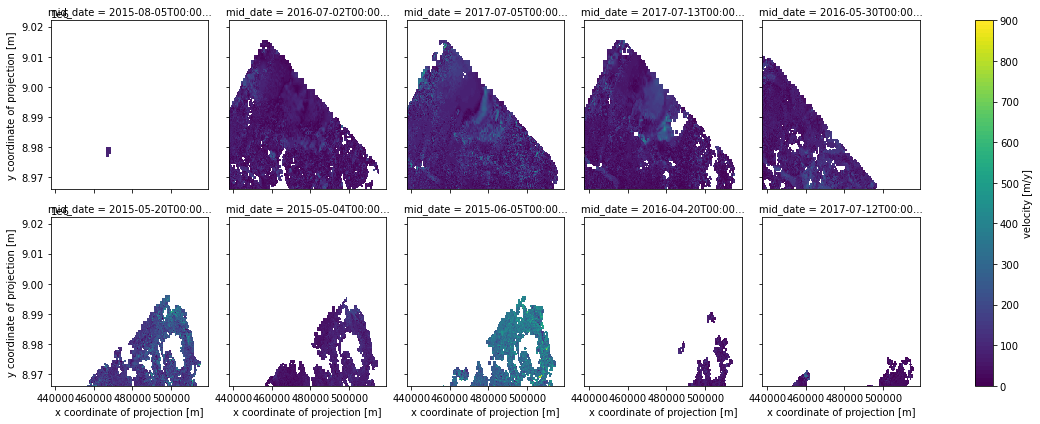

In [16]:
from itscube import ITSCube

back_zarr
# back_zarr['vx']
ITSCube.plot(back_zarr, 'v', (0, 10))


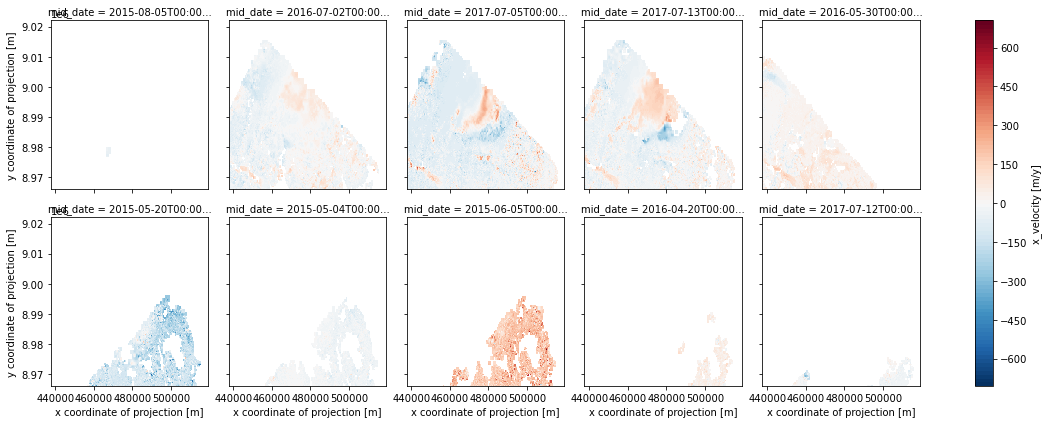

In [15]:
from itscube import ITSCube

ITSCube.plot(back_zarr, 'vx', (0, 10))

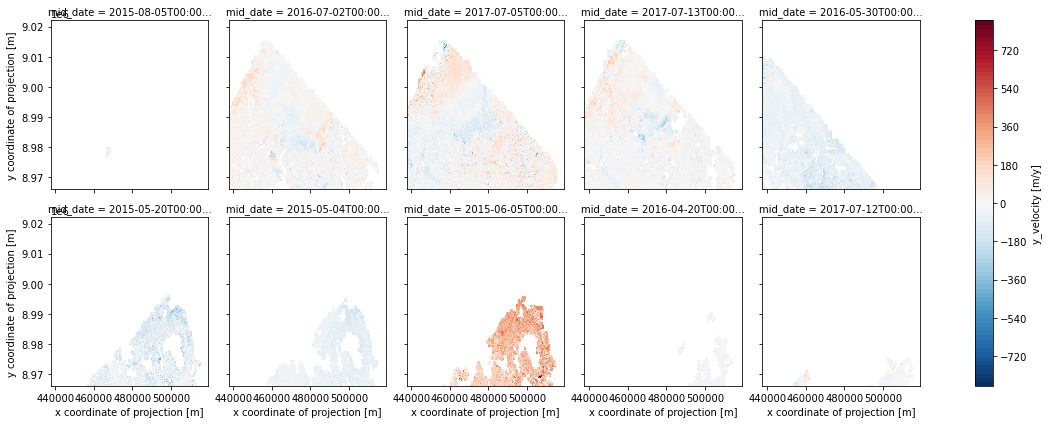

In [17]:
cube.plot(back_zarr, 'vy', (0, 10))

#### Display layers [40:50] of the cube

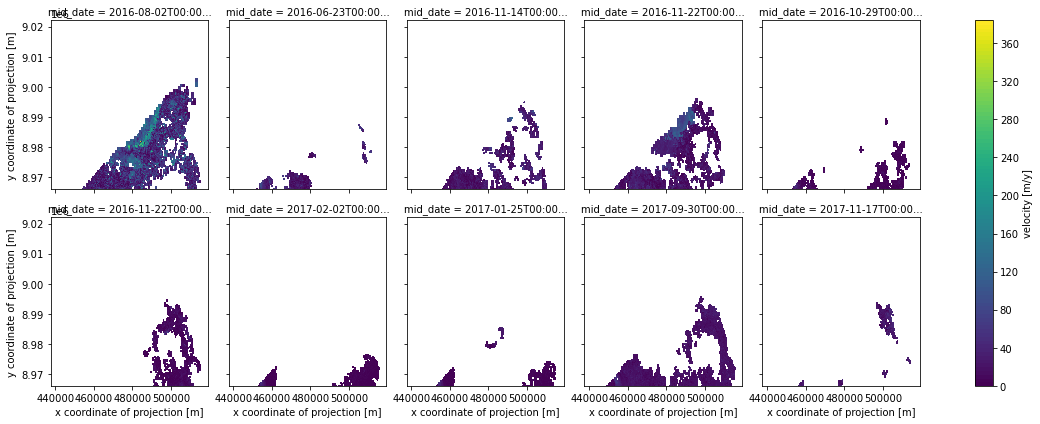

In [19]:
cube.plot(back_zarr, 'v', (40, 50))